# Grah colouring problem

The graph coloring problem is a fundamental challenge in computer science that involves assigning colors to the vertices of a graph such that no two adjacent vertices share the same color.

In this notebook, we are going to model and solve a graph coloring problem using the Python package `pyChoco`.

First of all, we need to import the necessary libraries.

In [2]:
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from libpysal import weights

We can read in the data and construct the graph. The instructions are taken from [NetworkX](https://networkx.org/documentation/stable/auto_examples/geospatial/plot_polygons.html).

In [3]:
filepath = "data/africa_no_islands.gpkg"
africa_countries = gpd.read_file(filepath)
africa_countries = africa_countries.to_crs(crs=3857)
centroids = np.column_stack((africa_countries.centroid.x, africa_countries.centroid.y))
queen = weights.Queen.from_dataframe(africa_countries, silence_warnings = True)
graph = queen.to_networkx()
positions = dict(zip(graph.nodes, centroids))

/tmp/ipykernel_110712/270330621.py:5: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  queen = weights.Queen.from_dataframe(africa_countries, silence_warnings = True)


We can now plot the graph and the connected countries.

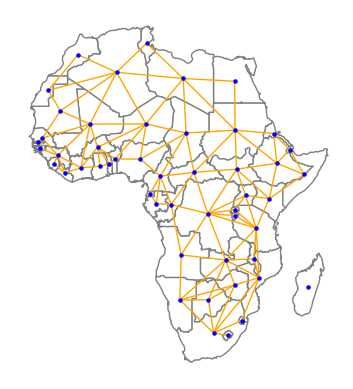

In [4]:
# plot with a nice basemap
ax = africa_countries.plot(linewidth=1, edgecolor="grey", facecolor="white")
ax.axis("off")
nx.draw(graph, positions, ax=ax, node_size=5, node_color="blue", edge_color="orange")
plt.show()

## Model the problem as a CSP

Choco makes it easy  to model the graph coloring problem as a CSP. We use the `all_different` constraint to ensure that no two adjacent vertices share the same color.
First of all, we need to declare the model.

In [5]:
from pychoco import Model
model = Model("Graph Coloring")

Then the variables can be declared. We have one variable for each country. The domain of each variable is the set of colors.
Four colors are enough to color the map in such a way that no two adjacent countries share the same color.

In [6]:
vars = [model.intvar(0, 3, name=africa_countries['COUNTRY'][c]) for c in graph.nodes]

Now, we add the constraints. We need to ensure that no two adjacent countries share the same color.
To do so, as a first step, we need to find all the cliques in the graph. A clique is a subset of vertices of an undirected graph such that every two distinct vertices in the clique are adjacent.
In our case, each clique represents a set of adjacent countries.
Thus, countries in the same clique cannot share the same color. To ensure this, we can use the `all_different` constraint, one for each clique.

In [7]:
all_cliques = nx.find_cliques(graph)
for clique in all_cliques:
    model.all_different([vars[c] for c in clique]).post()

Everything is ready. The problem can be solved.
There are many solutions to the problem, but finding one is enough to color the map.

In [19]:
model.get_solver().solve()

True

We can now plot the solution.
Each variable is associated with a country. The value of the variable is the color of the country, from 0 to 3.

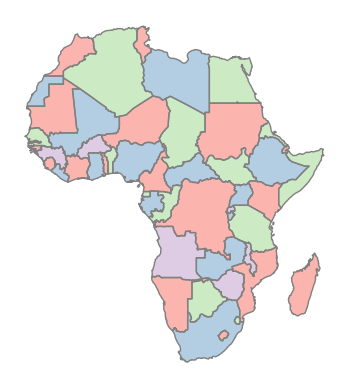

In [20]:
ax = africa_countries.boundary.plot(linewidth=1, edgecolor="grey",)
ax.axis("off")
cmap = plt.matplotlib.colormaps.get_cmap('Pastel1')
colors = [cmap(i) for i in range(4)]
for var in vars:
    #print(vars[i].name, colors[vars[i].get_value()])
    africa_countries[africa_countries.COUNTRY == var.name].plot(color=colors[var.get_value()], ax=ax)
plt.show()

The following code plots the map with the countries colored according to the solution.
We can visually check that no two adjacent countries share the same color.